In [2]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

maps =  ["project4_EP/sourceNotebooks/data/HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits"]

for x in range(len(maps)):
    beam = 10
    filepath = maps[x]

    pl = hp.read_map(filepath)
    pl[pl<-1e23]=0
    shape,wcs = enmap.fullsky_geometry(res=int(beam)*utils.arcmin,proj='car')
    map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)

    awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/src/wh22.csv', skiprows = 0)
    
    zs = [0, 0.72, 100]
    masses = [0, 1, 100000]

    stacks3 = []
    lens = []
    riches = []
    reds = []

    for j in tqdm(range(len(zs))):
        for k in range(len(masses)):
            if k == 1 or k == 2:
                continue
            stack_CMB_kSZ           = 0
            stack_CMB_kSZ_deproject = 0
            c = 0
            riches.append(masses[k])
            reds.append(zs[j])
            if j == len(zs)-1:
                if k == len(masses)-1:
                    ras = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['ra'].reset_index(drop=True)
                    decs = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['dec'].reset_index(drop=True)
                else:
                    ras = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['ra'].reset_index(drop=True)
                    decs = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['dec'].reset_index(drop=True)
            elif k == len(masses)-1:
                ras = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['ra'].reset_index(drop=True)
                decs = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['dec'].reset_index(drop=True)
            else:
                ras = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['ra'].reset_index(drop=True)
                decs = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['dec'].reset_index(drop=True)

            N = len(ras)
            lens.append(N)

            for i in tqdm(range(N)):
                stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=beam*utils.arcmin)

                if stamp is None:
                    continue
                elif stamp[0][0][0]==0.0:
                    continue
                else:
                    stack_CMB_kSZ += np.array(stamp)
                    c+=1

            # Normalize the stamps
            stack_CMB_kSZ /= c
            stack_CMB_kSZ_deproject /= c

            stacks3.append(stack_CMB_kSZ[0])
    np.save('353_fix2.npy'.format(x),stacks3)
    np.savetxt('lens.txt',lens)

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/35902 [00:00<?, ?it/s]

  0%|          | 0/27954 [00:00<?, ?it/s]

  0%|          | 0/63863 [00:00<?, ?it/s]

In [9]:
stacks = np.load('_stacks_act_353_0.npy')
stacks2 = np.load('353_fix.npy')
stacks3 = np.load('353_fix2.npy')

stacks[0] = stacks3[0]
stacks[1] = stacks2[0]
stacks[3] = stacks3[1]
stacks[4] = stacks2[1]
stacks[6] = stacks3[2]
stacks[7] = stacks2[2]

lens = [35902,38207,75021,27954,47132,76209,63863,85346,151244]

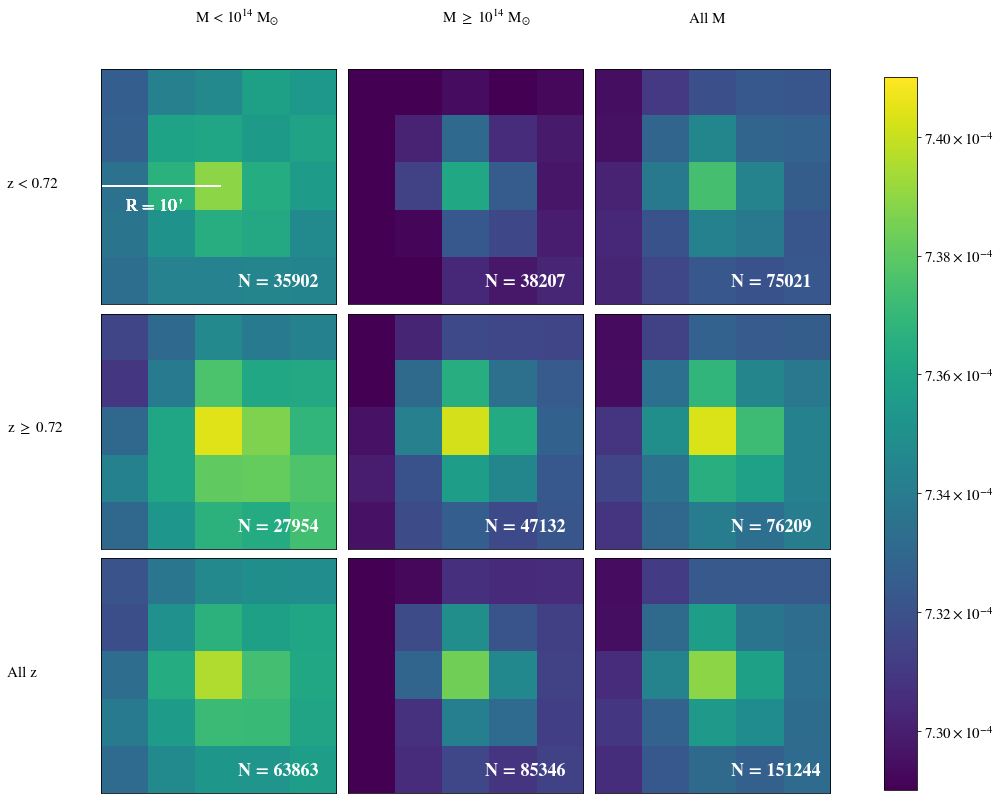

In [28]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

f, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
i = 0

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for j,row in enumerate(ax):
    for k, col in enumerate(row):
        f1 = col.imshow(stacks[i], vmin=0.000729, vmax=0.000741)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
#         plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02)
#         cbar = plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02)
#         cbar.ax.tick_params(rotation=25)

        scalebar = AnchoredSizeBar(ax[0][0].transData,
                                   2.5, '', 'center left', 
                                   pad=0.,
                                   sep=-7,
                                   color='white',
                                   frameon=False,
                                   size_vertical=0.02)
        ax[0][0].add_artist(scalebar)
        ax[0][0].text(0.1, 0.4, 'R = 10$\,$\''.format(10), c='white', fontsize=18, transform=ax[0][0].transAxes)

        col.text(2.4,4.12,"N = {}".format(lens[i]),fontsize=18,color='white',weight=600)
#         if j==0 and k==0:
#             col.text(-15,20,"z<0.72",size=15)
#         if j==1 and k==0:
#             col.text(-15,20,"z>0.72",size=15)
#         if j==2 and k==0:
#             col.text(-15,20,"all z",size=15)
#         if k==0 and j==0:
#             col.text(15,-5,"M<1$M_{\astrosun}$",size=15)
#         if k==1 and j==0:
#             col.text(15,-5,"M>1$M_{\astrosun}$",size=15)
#         if k==2 and j==0:
#             col.text(15,-5,"all M",size=15)
        if j==0 and k==0:
            col.text(-.4,.5,"z < 0.72",size=15,transform=col.transAxes)
        if j==1 and k==0:
            col.text(-.4,.5,"z $\geq$ 0.72",size=15,transform=col.transAxes)
        if j==2 and k==0:
            col.text(-.4,.5,"All z",size=15,transform=col.transAxes)
        if k==0 and j==0:
            col.text(.4,1.2,"M < 10$^{14}$ M$_{\odot}$",size=15,transform=col.transAxes)
        if k==1 and j==0:
            col.text(.4,1.2,"M $\geq$ 10$^{14}$ M$_{\odot}$",size=15,transform=col.transAxes)
        if k==2 and j==0:
            col.text(.4,1.2,"All M",size=15,transform=col.transAxes)

        i+=1
    
f.subplots_adjust(right=0.8)
plt.subplots_adjust(wspace=0.05, hspace=-0.25)
cbar_ax = f.add_axes([0.85, 0.17, 0.03, 0.66])
cbar = f.colorbar(f1, cax=cbar_ax, format=FuncFormatter(fmt))
cbar.ax.tick_params(labelsize=15) 

plt.savefig("353.png".format(x))


In [46]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
import random
import time
import multiprocessing as mp
import numpy as np
import random
import time
import multiprocessing as mp
import numpy as np
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

def make_stacked_plots(stacks,beam):
    f, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
    i = 0

    for j,row in enumerate(ax):
        for k, col in enumerate(row):
            f1 = col.imshow(stacks[i])
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            fmt = lambda x, pos: '{:.1e}'.format(x)            
            cbar = plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02, format=FuncFormatter(fmt))
            cbar.ax.tick_params(rotation=25)

            scalebar = AnchoredSizeBar(ax[0][0].transData,
                                       2.5, '', 'center left', 
                                       pad=0.,
                                       sep=-7,
                                       color='white',
                                       frameon=False,
                                       size_vertical=0.04)
            ax[0][0].add_artist(scalebar)
            ax[0][0].text(0.1, 0.4, 'R = {}\''.format(beam), c='white', transform=ax[0][0].transAxes)
            
            col.text(0.7,0.1,"N = {}".format(int(lens[i])),color='white',transform=col.transAxes)
            if j==0 and k==0:
                col.text(-.5,.5,"z<0.32",size=15,transform=col.transAxes)
            if j==1 and k==0:
                col.text(-.5,.5,"z>0.32",size=15,transform=col.transAxes)
            if j==2 and k==0:
                col.text(-.5,.5,"all z",size=15,transform=col.transAxes)
            if k==0 and j==0:
                col.text(.4,1.2,"rh<27",size=15,transform=col.transAxes)
            if k==1 and j==0:
                col.text(.4,1.2,"rh>27",size=15,transform=col.transAxes)
            if k==2 and j==0:
                col.text(.4,1.2,"all rh",size=15,transform=col.transAxes)

            i+=1

    plt.savefig("x_planck_stacked_143.png")
    plt.show()

In [47]:
beam = 9.659#4.216, 4.675, 4.916, 4.90, 7.220, 9.659
rosat = np.load('npy_files/x_stacks_planck_0.npy')
lens = np.loadtxt('npy_files/lens.txt')

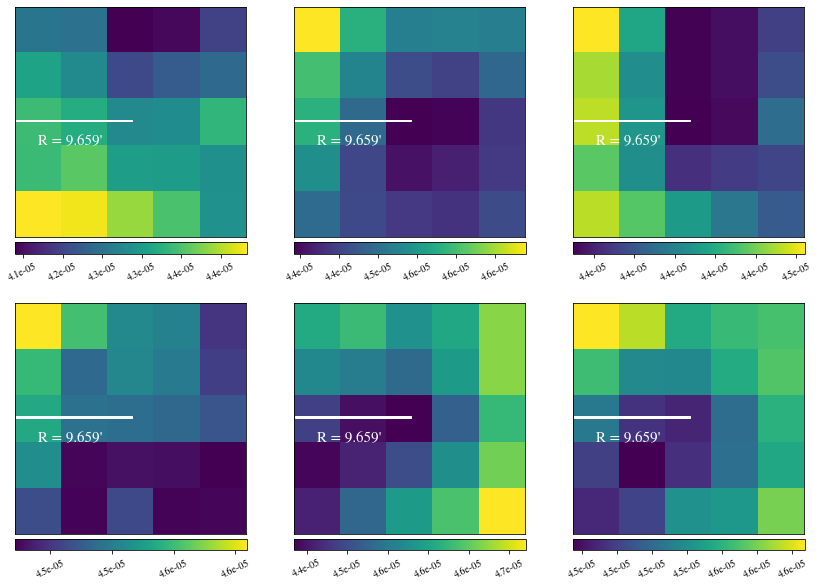

In [48]:
make_stacked_plots(rosat,beam)